In [ ]:




import shutil # used for function like moving ,copying , delete a file or directory

import os


os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Move kaggle.json to the .kaggle directory
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))


!kaggle datasets download -d yewtsing/pretty-face



FileNotFoundError: [Errno 2] No such file or directory: 'kaggle.json'

In [ ]:
!unzip pretty-face.zip

Streaming output truncated to the last 5000 lines.
  inflating: layout/layout/020203.png  
  inflating: layout/layout/020215.png  
  inflating: layout/layout/020216.png  
  inflating: layout/layout/020233.png  
  inflating: layout/layout/020259.png  
  inflating: layout/layout/020276.png  
  inflating: layout/layout/020285.png  
  inflating: layout/layout/020303.png  
  inflating: layout/layout/020322.png  
  inflating: layout/layout/020326.png  
  inflating: layout/layout/020337.png  
  inflating: layout/layout/020354.png  
  inflating: layout/layout/020358.png  
  inflating: layout/layout/020367.png  
  inflating: layout/layout/020370.png  
  inflating: layout/layout/020381.png  
  inflating: layout/layout/020386.png  
  inflating: layout/layout/020395.png  
  inflating: layout/layout/020400.png  
  inflating: layout/layout/020408.png  
  inflating: layout/layout/020410.png  
  inflating: layout/layout/020421.png  
  inflating: layout/layout/020437.png  
  inflating: layout/layout/02

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers


In [ ]:
def image2numpy_array(image_folder,image_size =(64,64)):

  Image_data = []

  for img in os.listdir(image_folder):
    image_path = os.path.join(image_folder,img)

    if image_path.endswith(('.jpg','.png','.jpeg')):
       imagex= cv.imread(image_path)
       image2 = cv.cvtColor(imagex,cv.COLOR_BGR2RGB)
       image_resized = cv.resize(image2,image_size)
       array = np.array(image_resized)
       Image_data.append(array)
  image_data = np.stack(Image_data)
  return image_data







In [ ]:
image_folder= r'/content/face/face'
Data =image2numpy_array(image_folder)
print(Data.shape)



(3318, 64, 64, 3)


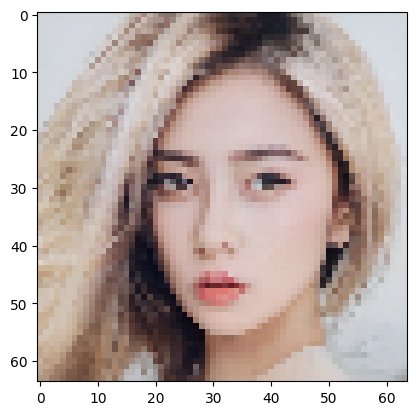

In [ ]:
plt.imshow(Data[1])


In [ ]:

 def build_generator(latent_dim):
   model= models.Sequential()
   model.add(layers.Dense(8*8*128,input_dim = latent_dim))
   model.add(layers.LeakyReLU(alpha=0.2))
   model.add(layers.Reshape((8,8,128)))
   model.add(layers.UpSampling2D()) #(16,16)
   model.add(layers.Conv2DTranspose(128,(3,3),padding='same'))
   model.add(layers.LeakyReLU(alpha=0.2))
   model.add(layers.UpSampling2D()) #(32,32)
   model.add(layers.Conv2DTranspose(128,(3,3),padding='same'))
   model.add(layers.LeakyReLU(alpha=0.2))
   model.add(layers.UpSampling2D()) #(64,64)
   model.add(layers.Conv2DTranspose(128,(3,3),padding='same'))
   model.add(layers.LeakyReLU(alpha=0.2))
   model.add(layers.Conv2DTranspose(3,(3,3),padding='same',activation='tanh'))
   return model

In [ ]:
def build_discriminator(input_shape = (64,64,3)):
  model = models.Sequential()
  model.add(layers.Conv2D(64,(3,3), strides =2 ,padding='same',input_shape=input_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(128,(3,3), strides =2 ,padding='same',))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(256,(3,3), strides =2 ,padding='same',))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())#dense want 1D vector as input so flatten function is used
  model.add(layers.Dense(1, activation='sigmoid'))#sigmoid is used instead of tanh because it is better for binary classification
  return model


In [ ]:
def build_gan(generator, discriminator):   #define the GAN MODEL
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
latent_dim = 100
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

generator = build_generator(latent_dim)
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


In [ ]:
X_train = (Data.astype(np.float32) - 127.5) / 127.5

In [ ]:
def train_gan(epochs=300, batch_size=64, latent_dim=100, X_train=X_train):
    half_batch = batch_size // 2
    total_batches = X_train.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(total_batches):
            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            fake_images = generator.predict(noise)

            d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))


        print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss[0]} - G Loss: {g_loss}")

        if epoch % 2 == 0:
            save_and_print_generated_images(epoch)

s
def save_and_print_generated_images(epoch, examples=10, figsize=(10, 2)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1] range

    fig, axs = plt.subplots(1, examples, figsize=figsize)
    for i in range(examples):
        axs[i].imshow(generated_images[i])
        axs[i].axis('off')
    plt.show()
    fig.savefig(f"gan_generated_image_{epoch}.png")
    plt.close()



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

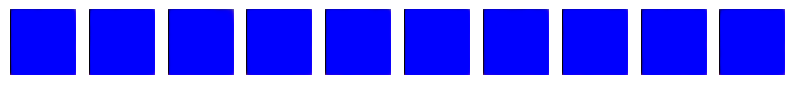

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [ ]:
train_gan(epochs=500, batch_size=64, latent_dim=latent_dim, X_train=X_train)

In [ ]:
generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

generator = load_model("generator_model.h5")
discriminator = load_model("discriminator_model.h5")  # Save and load this if not already done


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


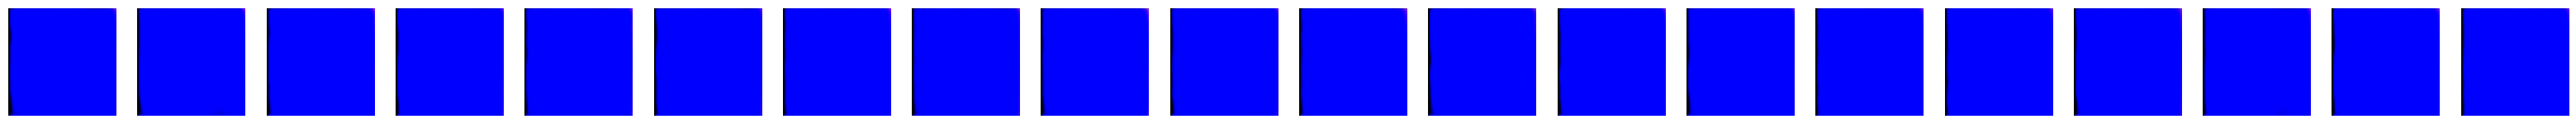

In [ ]:

# Load the trained generator model
generator_path = "generator_model.h5"  # Path to your saved generator model
generator = load_model(generator_path)

# Define the latent dimension (must match the one used during training)
latent_dim = 100

# Function to generate and display images
def generate_images(generator, num_images=10, latent_dim=100):
    # Generate random noise
    noise = np.random.normal(0, 1, (num_images, latent_dim))

    # Generate images
    generated_images = generator.predict(noise)

    # Rescale images to [0, 1] for display
    generated_images = 0.5 * generated_images + 0.5

    # Display the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i])
        axs[i].axis('off')
    plt.show()

# Generate and display images
generate_images(generator, num_images=20, latent_dim=latent_dim)